In [1]:
import numpy as np # linear algebra
from matplotlib import pyplot as plt
#We need these in this file:
import sys
sys.path.append('cropping')
import load_read_name_extractor as lrne
import SVM_classifier_general as svm_general

In [2]:
img_list, names = lrne.load_name_and_img("cropped_mean/*jpeg")

In [3]:
print(len(img_list))
print(len(names))

4915
4915


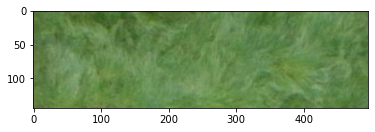

cropped_mean/69_200612_Min.jpeg


In [4]:
import random

# pick a random index
random_index = random.randint(0, len(img_list)-1)

# get the corresponding image and name
random_img = img_list[random_index]
random_name = names[random_index]

# show the image and print the name
plt.imshow(random_img)
plt.show()
print(random_name)


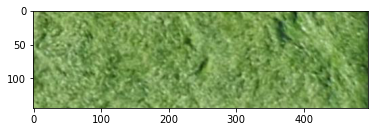

cropped_mean/124_200528_Min.jpeg


In [5]:
# show the first image and print the name
plt.imshow(img_list[0])
plt.show()
print(names[0])


In [6]:
date_ = False
bin_size = 20
n_bins = int(np.floor(100/bin_size))
labels = svm_general.load_labels(bin_size, date_)
print(labels[0])
print(len(labels))

#convert names into [flight_folder, ROI]
names_labels = lrne.it_name_extract_labels_from_img_jpeg(names)
print(names_labels[0])
lodging_score = [[] for _ in range(4915)]

['149' '1' '200612_Min' '0']
4936
['124', '200528_Min']


In [7]:
#match labels with feature names
lodging_score = svm_general.match_pic_label_to_names_new(lodging_score, labels, names_labels, date_)

In [8]:
import itertools
print(lodging_score)

lodging_score_int = [[int(char) for char in sublist] for sublist in lodging_score]

flattened_list = list(itertools.chain.from_iterable(lodging_score_int))
#print(flattened_list)
lodging_score = flattened_list
#print(max(lodging_score_int))

[['0'], ['0'], ['1'], ['1'], ['0'], ['1'], ['2'], ['1'], ['0'], ['1'], ['0'], ['0'], ['0'], ['3'], ['0'], ['3'], ['0'], ['0'], ['1'], ['1'], ['0'], ['0'], ['0'], ['2'], ['0'], ['1'], ['0'], ['0'], ['3'], ['1'], ['0'], ['0'], ['0'], ['0'], ['0'], ['0'], ['0'], ['0'], ['1'], ['0'], ['2'], ['0'], ['0'], ['3'], ['0'], ['3'], ['0'], ['0'], ['1'], ['0'], ['2'], ['2'], ['0'], ['3'], ['0'], ['0'], ['3'], ['2'], ['1'], ['2'], ['0'], ['0'], ['3'], ['2'], ['3'], ['0'], ['1'], ['0'], ['2'], ['0'], ['2'], ['0'], ['1'], ['1'], ['0'], ['0'], ['4'], ['1'], ['0'], ['1'], ['0'], ['2'], ['1'], ['2'], ['1'], ['0'], ['0'], ['3'], ['2'], ['0'], ['0'], ['3'], ['2'], ['0'], ['1'], ['3'], ['0'], ['3'], ['0'], ['0'], ['2'], ['0'], ['0'], ['0'], ['0'], ['0'], ['0'], ['3'], ['0'], ['3'], ['2'], ['3'], ['0'], ['0'], ['1'], ['0'], ['0'], ['0'], ['0'], ['2'], ['0'], ['3'], ['1'], ['1'], ['2'], ['2'], ['0'], ['0'], ['0'], ['1'], ['0'], ['0'], ['1'], ['0'], ['3'], ['0'], ['3'], ['0'], ['0'], ['3'], ['0'], ['1'], ['2']

In [9]:
count_9 = lodging_score.count(9)
print(count_9)


0


In [10]:
print(np.shape(img_list))
print(np.shape(flattened_list))

(4915, 144, 496, 3)
(4915,)


In [11]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [12]:
def calculate_mean(self):
    # Calculate the mean pixel intensity across all images
    total_pixels = 0
    sum_pixel_values = torch.zeros(3)  # Assuming images are in RGB format

    for img in self.img_list:
        img_tensor = torch.tensor(img).permute(2, 0, 1).float()
        total_pixels += img_tensor.size(1) * img_tensor.size(2)
        sum_pixel_values += torch.sum(img_tensor, dim=(1, 2))

    mean_pixel = sum_pixel_values / total_pixels

    return mean_pixel

In [13]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from torchvision import transforms

class ImageDataset(Dataset):
    def __init__(self, img_list, lodging_score, transform=None):
        self.img_list = img_list
        self.lodging_score = lodging_score
        self.transform = transform
        self.mean = 0
        
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, idx):
        img = self.img_list[idx]
        score = self.lodging_score[idx]

        # Convert image to tensor and apply transformations
        if self.transform:
            img = self.transform(img)

        return img, score
    def get_labels(self):
        return self.lodging_score

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((144, 496)),
    #transforms.Grayscale(),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.5], std=[0.5])
])

dataSet = ImageDataset(img_list, lodging_score, transform=transform)
print(dataSet[0][0].mean(dim=-1))


tensor([[0.4237, 0.4237, 0.4323, 0.4423, 0.4465, 0.4512, 0.4577, 0.4603, 0.4625,
         0.4632, 0.4618, 0.4585, 0.4562, 0.4559, 0.4576, 0.4597, 0.4646, 0.4655,
         0.4623, 0.4558, 0.4502, 0.4483, 0.4481, 0.4496, 0.4509, 0.4531, 0.4579,
         0.4613, 0.4608, 0.4621, 0.4656, 0.4686, 0.4710, 0.4669, 0.4582, 0.4477,
         0.4383, 0.4343, 0.4399, 0.4494, 0.4589, 0.4628, 0.4614, 0.4593, 0.4615,
         0.4609, 0.4593, 0.4611, 0.4653, 0.4652, 0.4609, 0.4547, 0.4514, 0.4538,
         0.4549, 0.4533, 0.4517, 0.4488, 0.4461, 0.4447, 0.4420, 0.4393, 0.4372,
         0.4359, 0.4390, 0.4403, 0.4408, 0.4421, 0.4458, 0.4477, 0.4472, 0.4462,
         0.4448, 0.4457, 0.4487, 0.4496, 0.4489, 0.4503, 0.4523, 0.4519, 0.4481,
         0.4452, 0.4425, 0.4423, 0.4432, 0.4432, 0.4404, 0.4364, 0.4334, 0.4333,
         0.4347, 0.4373, 0.4402, 0.4433, 0.4443, 0.4428, 0.4384, 0.4379, 0.4428,
         0.4468, 0.4459, 0.4451, 0.4496, 0.4540, 0.4575, 0.4571, 0.4569, 0.4549,
         0.4532, 0.4523, 0.4

In [14]:
#Split into train and validation set
random_seed = 10587
testValSize = (2/5) * len(dataSet)
trainDataset, testvalDataset = train_test_split(dataSet, test_size=int(testValSize), random_state=random_seed, shuffle=True)
validationSize = (1/2) * len(testvalDataset)
testDataset, valDataset = train_test_split(testvalDataset, test_size=int(validationSize), random_state=random_seed, shuffle=True)

#Create dataloaders
batchSize = 64
trainDataloader = DataLoader(trainDataset, batch_size=batchSize, shuffle=True)
testDataloader = DataLoader(testDataset, batch_size=batchSize, shuffle=True)
valDataloader = DataLoader(valDataset, batch_size=batchSize, shuffle=True)

#Print sizes
print(len(trainDataset), len(testDataset), len(valDataset))
print(dataSet[0][0].shape)

2949 983 983
torch.Size([3, 144, 496])


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
num_classes = 5
channels = dataSet[0][0].shape[0]
height = dataSet[0][0].shape[1]
width = dataSet[0][0].shape[2]
print(channels)
print(height)
print(width)


3
144
496


In [16]:
output_size = (input_size - kernel_size + 2 * padding) // stride + 1
print(output_size)


67


In [25]:
kernel_size = 3
kernel_size1 = 3
# define network
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        #Takes in 3, 144, 496
        self.conv1 = nn.Conv2d(3,16,kernel_size, padding="same")
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(16,16,kernel_size1, padding="same")
        self.conv3 = nn.Conv2d(16,16,kernel_size, padding="same")
        self.conv4 = nn.Conv2d(16,16,kernel_size1, padding="same")
        self.flatten = nn.Flatten()
        self.FC1 = nn.Linear(9*31*16, 128)
        self.FC2 = nn.Linear(128, num_classes)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax()


    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        #print(x.shape)
        x = self.pool(x)
        #print(x.shape)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        #print(x.shape)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool(x)
        #print(x.shape)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.pool(x)
        #print(x.shape)

        x = self.flatten(x)
        x = self.FC1(x)
        x = F.relu(x)
        x = self.FC2(x)
        return x


In [30]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
net = NeuralNetwork()
net.to(device)
print(net)
# Define the loss function
criterion = nn.CrossEntropyLoss().to(device)

# Define the optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=1000000, verbose=True)

# Set the number of epochs
num_epochs = 50
totalAcc = 0
# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    totalAcc = 0.0
    val_running_loss = 0.0
    val_totalAcc = 0.0
    for i, data in enumerate(trainDataloader, 0):
        # Get the inputs and labels
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = net(inputs)
        #print(outputs.shape)
        #print(outputs[0])
        totalAcc += torch.eq(torch.argmax(outputs, dim=1), labels).sum()
        #print(torch.argmax(outputs, dim=1))
        #print(torch.argmax(outputs, dim=1).shape)
        #print(outputs.shape)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
    for i, data in enumerate(valDataloader, 0):
        net.eval()
        # Get the inputs and labels
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # Forward pass
        outputs = net(inputs)
        #print(outputs.shape)
        val_totalAcc += torch.eq(torch.argmax(outputs, dim=1), labels).sum()
        #print(torch.argmax(outputs, dim=1))
        #print(torch.argmax(outputs, dim=1).shape)
        #print(outputs.shape)
        loss = criterion(outputs, labels)

        # Print statistics
        val_running_loss += loss.item()
    scheduler.step(val_running_loss)
    net.train()
    print('[%d] train loss: %.3f train acc: %.3f val loss: %.3f val acc: %.3f ' % (epoch + 1, running_loss / len(trainDataloader), totalAcc/len(trainDataset), val_running_loss / len(valDataloader), val_totalAcc/len(valDataset)))
    running_loss = 0.0
    totalAcc = 0.0
    val_running_loss = 0.0
    val_totalAcc = 0.0

print('Finished training')


NeuralNetwork(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (FC1): Linear(in_features=4464, out_features=128, bias=True)
  (FC2): Linear(in_features=128, out_features=5, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=None)
)
[1] train loss: 1.169 train acc: 0.566 val loss: 1.133 val acc: 0.599 
[2] train loss: 1.002 train acc: 0.627 val loss: 0.916 val acc: 0.666 
[3] train loss: 0.950 train acc: 0.649 val loss: 0.906 val acc: 0.652 
[4] train loss: 0.935 train acc: 0.634 val loss: 0.894 val acc: 0.684 
[5] train loss: 0.853 train acc: 0.668 val loss: 0.916 val acc: 0.679 
[6] train loss: 0.817

In [27]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np

# Assuming you have a trained model named 'model' and a DataLoader named 'dataloader'
# You also need the true labels for your dataset (ground truth)
# Ensure your dataloader returns the true labels along with the images

# Set the model to evaluation mode
net.eval()

# Lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

for i, data in enumerate(valDataloader, 0):
    net.eval()
    # Get the inputs and labels
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    # Forward pass
    outputs = net(inputs)
    _, predicted = torch.max(outputs, 1)  # Assuming a classification task with softmax activation
    # Move tensors to CPU before extending lists
    true_labels.extend(labels.cpu().numpy())
    predicted_labels.extend(predicted.cpu().numpy())

# Convert lists to NumPy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

Confusion Matrix:
[[534  36  12   8   0]
 [ 52  53  16  11   0]
 [ 25  32  33  17   0]
 [  8   7  15  84   7]
 [  0   0   0  20  13]]
Accuracy: 0.7293997965412004


In [29]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np

# Assuming you have a trained model named 'model' and a DataLoader named 'dataloader'
# You also need the true labels for your dataset (ground truth)
# Ensure your dataloader returns the true labels along with the images

# Set the model to evaluation mode
net.eval()

# Lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

for i, data in enumerate(trainDataloader, 0):
    net.eval()
    # Get the inputs and labels
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    # Forward pass
    outputs = net(inputs)
    _, predicted = torch.max(outputs, 1)  # Assuming a classification task with softmax activation
    # Move tensors to CPU before extending lists
    true_labels.extend(labels.cpu().numpy())
    predicted_labels.extend(predicted.cpu().numpy())

# Convert lists to NumPy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

Confusion Matrix:
[[1603   62   11   12    0]
 [ 118  298   23   17    0]
 [  41   38  175   47    0]
 [  14    8   16  384    7]
 [   0    0    3   30   42]]
Accuracy: 0.8484231943031536


In [20]:
test_totalAcc = 0.0
test_running_loss = 0.0
for i, data in enumerate(testDataloader, 0):
    net.eval()
    # Get the inputs and labels
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    # Forward pass
    outputs = net(inputs)
    #print(outputs.shape)
    test_totalAcc += torch.eq(torch.argmax(outputs, dim=1), labels).sum()
    #print(torch.argmax(outputs, dim=1))
    #print(torch.argmax(outputs, dim=1).shape)
    #print(outputs.shape)
    loss = criterion(outputs, labels)

    # Print statistics
    test_running_loss += loss.item()
print('test loss: %.3f test acc: %.3f' % (test_running_loss / len(testDataloader), test_totalAcc/len(testDataset)))
test_totalAcc = 0.0
test_running_loss = 0.0

test loss: 0.712 test acc: 0.720


In [21]:
import matplotlib.pyplot as plt

# Extract the labels from the trainDataloader
labels = [data[1] for data in trainDataloader]


# Count the occurrences of each label
label_counts = {}
for label in labels:
    if label.item() in label_counts:
        label_counts[label.item()] += 1
    else:
        label_counts[label.item()] = 1

# Create a bar plot
plt.bar(label_counts.keys(), label_counts.values())
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution in trainDataloader')
plt.show()

ValueError: only one element tensors can be converted to Python scalars